<a href="https://colab.research.google.com/github/Fatemehbozorgi97/01-ad-de/blob/main/NewKNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Testing some features

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
data21 = pd.read_csv('IT-NO_2021_hourly.csv')
data22 = pd.read_csv('IT-NO_2022_hourly.csv')
data23 = pd.read_csv('IT-NO_2023_hourly.csv')
concatenated_df = pd.concat([data21, data22, data23], ignore_index=True)

df=concatenated_df.dropna(axis=1,how="all")
df1=df
df['Datetime (UTC)'] = pd.to_datetime(df['Datetime (UTC)'])

df['Datetime (UTC)'] = df['Datetime (UTC)'].dt.strftime('%Y%m%d%H')

df['Datetime (UTC)'] = df['Datetime (UTC)'].str.replace('-', '').str.replace(':', '')
df.head()
x=pd.DataFrame()
x['Datetime (UTC)']=df['Datetime (UTC)']
x['Carbon Intensity gCO₂eq/kWh (direct)']=df['Carbon Intensity gCO₂eq/kWh (direct)']
df = x
print(df.columns)
df.head()


Index(['Datetime (UTC)', 'Carbon Intensity gCO₂eq/kWh (direct)'], dtype='object')


,Datetime (UTC),Carbon Intensity gCO₂eq/kWh (direct)
0,2021010100,303.29
1,2021010101,303.45
2,2021010102,295.04
3,2021010103,295.56
4,2021010104,308.06


In [10]:
from sklearn.model_selection import train_test_split
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the 'LCA' column
lca_data = df['Carbon Intensity gCO₂eq/kWh (direct)']
dates = df['Datetime (UTC)']

# Create sequences of one month's data for 'X' and the following month's data for 'y'
def create_sequences(data, dates, window_size):
    X, y, date_seqs = [], [], []
    for i in range(len(data) - 2 * window_size + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + 2 * window_size])
        date_seqs.append(dates[i + window_size:i + 2 * window_size])
    return np.array(X), np.array(y), np.array(date_seqs)

# Define the window size (number of hours in a month)
window_size = 30 * 24  # 30 days * 24 hours

# Create the sequences
X, y, date_seqs = create_sequences(lca_data.values, dates.values, window_size)

# Display the shapes of X and y
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, date_seqs, test_size=0.2, random_state=42)



Shape of X: (24841, 720)
Shape of y: (24841, 720)


**KNN Model - predicting based on the prior month's data**

In [17]:
# Initialize the KNN model
from sklearn.neighbors import KNeighborsRegressor


knn_model = KNeighborsRegressor(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage

mae=np.mean(np.abs(y_test-y_pred))

In [18]:
# Print the results
print(f"Mean Squared Error: {mse}")
print(mae)
print(f"R-squared: {r2}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"Mean Absolute Percentage Error (based on mean of X_test): {mape_mean_x_test:.2f}%")

Mean Squared Error: 208.1494444329902
10.781528018716035
R-squared: 0.9503045123878502
Mean Absolute Percentage Error: 461.49%
Mean Absolute Percentage Error (based on mean of X_test): 1898.92%


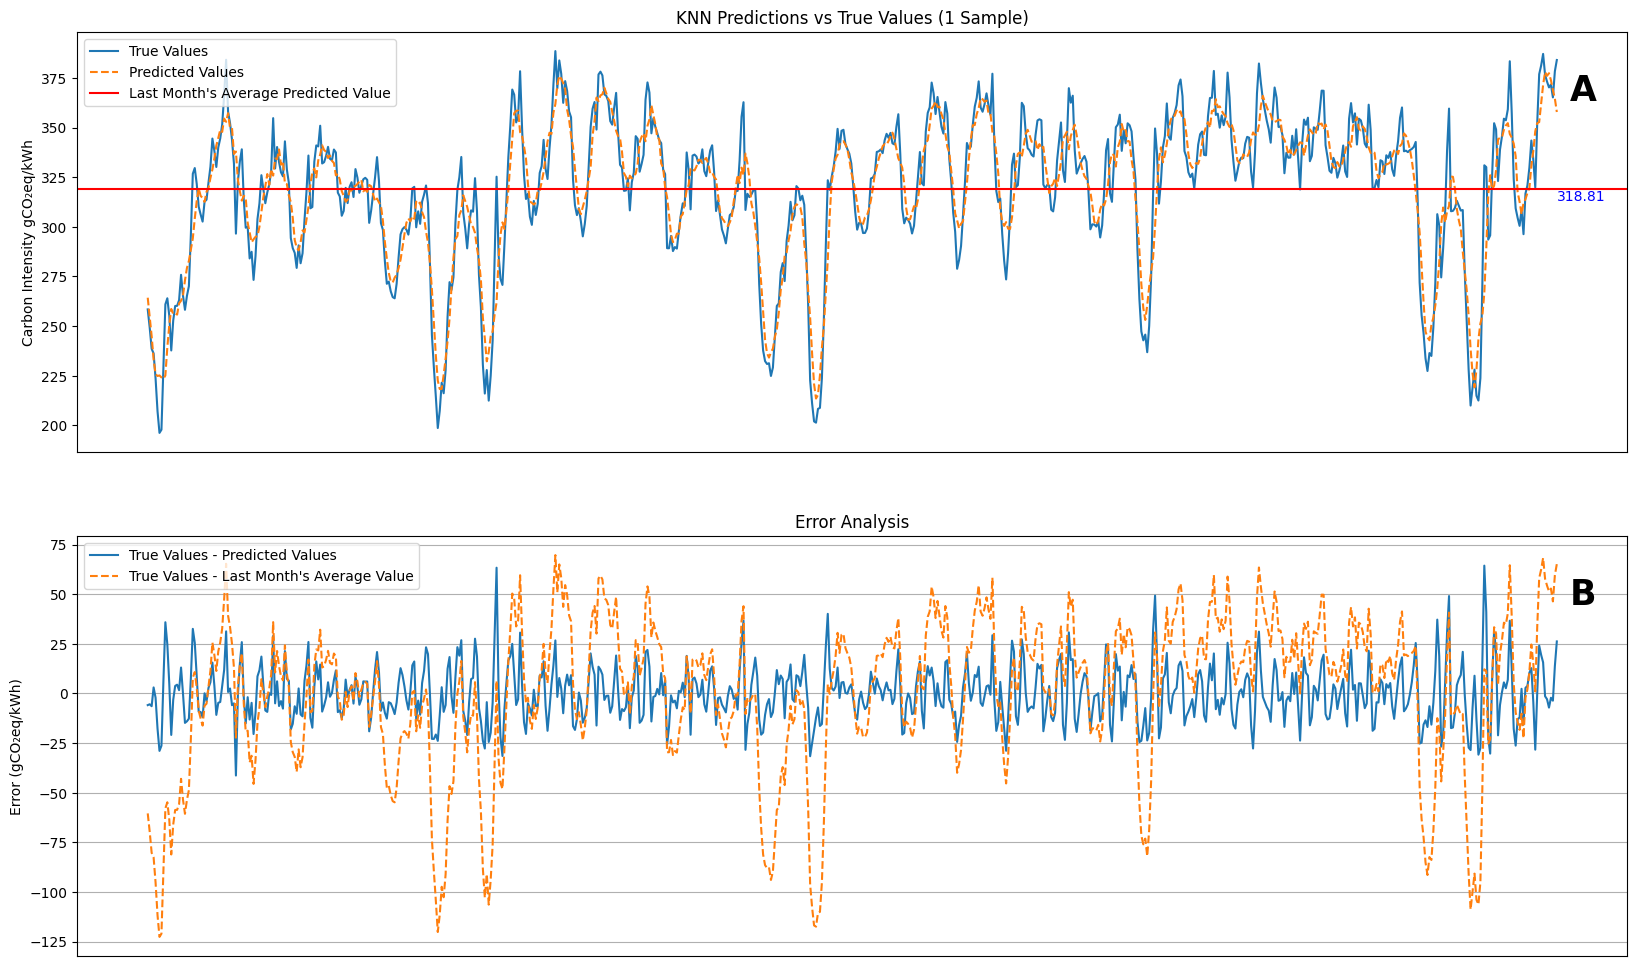

In [25]:
# Select 1 sample from the test set for plotting
num_samples = 1
indices = np.random.choice(len(y_test), num_samples, replace=False)

y_test_sample = y_test[indices][0]
y_pred_sample = y_pred[indices][0]
dates_sample = dates_test[indices][0]

# Convert date strings to datetime objects if necessary
# dates_sample = pd.to_datetime(dates_sample)

# Calculate the average value of the predictions for the last month
avg_last_month_pred = y_pred_sample.mean()

# Calculate errors
errors_true = y_test_sample - y_pred_sample
errors_avg = y_test_sample - avg_last_month_pred

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

# Plot the true vs predicted values
ax1.plot(dates_sample, y_test_sample, label='True Values')
ax1.plot(dates_sample, y_pred_sample, label='Predicted Values', linestyle='--')
ax1.axhline(y=avg_last_month_pred, color='r', linestyle='-', label="Last Month's Average Predicted Value")
ax1.text(dates_sample[-1], avg_last_month_pred, f'{avg_last_month_pred:.2f}', color='b', va='top')
ax1.set_ylabel('Carbon Intensity gCO₂eq/kWh')
ax1.set_title('KNN Predictions vs True Values (1 Sample)')
ax1.legend()

# Plot the errors
ax2.plot(dates_sample, errors_true, label='True Values - Predicted Values ')
ax2.plot(dates_sample, errors_avg, label="True Values - Last Month's Average Value", linestyle='--')
ax2.set_ylabel('Error (gCO₂eq/kWh)')
ax2.set_title('Error Analysis')
ax2.legend()
ax2.set_xticks([])
ax2.tick_params(axis='x', which='both', length=0)
# Set date format on X-axis to show every 5 days
# locator = mdates.DayLocator(interval=5)
# ax2.xaxis.set_major_locator(locator)
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.text(0.98, 0.9, 'A', transform=ax1.transAxes, fontsize=25, fontweight='bold', va='top', ha='right')
ax2.text(0.98, 0.9, 'B', transform=ax2.transAxes, fontsize=25, fontweight='bold', va='top', ha='right')
plt.xticks(rotation=45)
plt.grid(True)

# Save the figure
plt.savefig("KNN_Results.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()
